In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Source for SOFR rate: https://www.newyorkfed.org/markets/reference-rates/sofr

In [2]:
sofr_i=0.0533 ## SOFR Rate as on 09/12/2024
b_mat=30 ## Bond Maturity in years
bcr=0.055 ## Current Annualized Coupon Rate
cpy=1 ## Number of Coupons per year. For example, for a quarterly coupon this value will be 4.
bp=100 ## Face value of Bond

In [60]:
def dollar_duration(maturity,face_value,coupon_rate,yield_rate,compounding):
    """
    This function requires the following variables:
        maturity: Maturity of the bond in years
        face_value: face value of the bond
        coupon_rate: annualized coupon rate of the bond
        yield_rate: yield rate of the bond 
        compounding: numerical value of the number of coupons in a year. Must be an integer.
        
    The functon returns the following data:
        B - Bond Price: Present value of the bond at a given yield rate
        D - DV01: DV01 of the bond given the yield rate
        bond_cf: List of cashflows from the bond given the compounding scheme
        D1 - Modified Duration : Modified duration of the bond at the given yield rate
    """
    t=list(range(1,(maturity*compounding)+1))
    yld=yield_rate/compounding
    cpnr=coupon_rate/compounding
    cpnr_payment=face_value*cpnr
    bond_cf=[cpnr_payment]*len(t)
    bond_cf[len(t)-1]=bond_cf[len(t)-1]+face_value
    B=0
    D=0
    for i in range(1,len(t)+1):
        B+=bond_cf[i-1]/(1+yld)**i
    for j in range(1,len(t)+1):    
        D+=(j*bond_cf[j-1])/(((1+yld)**(j+1))*compounding)
    D1=D/face_value
    D2=-D1*0.0001*B
    return B,D,bond_cf,D1

A standard yield curve based on the SOFR has been simulated:
1. The "step" variable is assumed to be equal to 1 basis point
2. The "typ" variable takes in +/-1 depending on a normal or an inverted yield curve.
3. The generator attribute takes in the following inputs:
3.1. 0 for generating a flat yield curve
3.2. 1 for generating a linearly increasing yield curve
3.3. 2 for generating a quadratic spline with decreasing slope
3.4. 3 for generating a cubic spline with decreasing slope

Text(0, 0.5, 'Interest Rate')

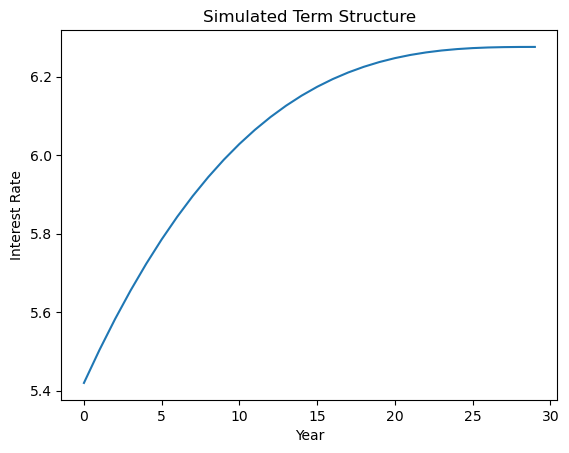

In [61]:
step=0.0001
def int_rate(ir,maturity,step,generator,typ=1):
    li=[]
    lit=ir
    p=0
    if generator==0:
        h=[0 for j in range(b_mat)]
        step_c=0
    elif generator==1:
        h=[1 for j in range(b_mat)]
        step_c=step
    elif generator==2:
        h=[b_mat-j for j in range(b_mat)]
        p=2
        step_c=step
    elif generator==3:
        h=[b_mat-j for j in range(b_mat)]
        p=3
        step_c=step
    for i in range(b_mat):
        lit=lit+typ*h[i]**p*step_c/(10**p)
        li.append(lit)
    return li

li=int_rate(sofr_i,b_mat,0.0001,2,1)
l=len(li)
li
g=[r*100 for r in li]    
plt.plot(g)
plt.title("Simulated Term Structure")
plt.xlabel("Year")
plt.ylabel("Interest Rate")

In [65]:
b=[]
dd=[]
d=[]
for k in range(l):
    b1,d1,cf1,d2=dollar_duration(b_mat,bp,bcr,li[k],cpy)
    if k==15: ## incoropating the put condition
        cf2=cf1[:k*cpy]
        cf2[len(cf2)-1]=cf2[len(cf2)-1]+bp
        B1=0
        D1=0
        for i1 in range(1,k+1):
            B1+=cf2[i1-1]/(1+li[k])**i1 ## generating current value of the bond with the put condition
        for j1 in range(1,k+1):    
            D1+=(j1*cf2[j1-1])/(((1+li[k])**(j1+1))*cpy) ## generating DV01 of the bond with the put condition
        D2=D1/bp
        D3=D2*0.0001*B1
        b.append(B1)
        dd.append(D3)
        d.append(D2)
    else:
        b.append(b1)
        dd.append(d1)
        d.append(d2)        

Text(15, 0.08588062435310873, 'x=15.000, y=0.086')

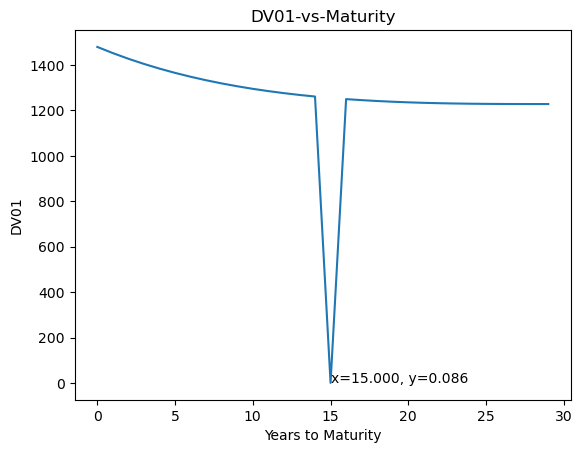

In [66]:
plt.plot(dd)
plt.title("DV01-vs-Maturity")
plt.xlabel("Years to Maturity")
plt.ylabel("DV01")
ymax = min(dd)
xmax = dd.index(ymax)
text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
plt.annotate(text, xy=(xmax, ymax))

The maximum exposure will be just before 15 years, when the put condition is scheduled for excercise.

The price of the puttable bond should be greater than that of a normal bond since it allows the investor to sell the bond at the stipulated time and reinvest the proceeds for higher returns, in case of the availability of such options. 

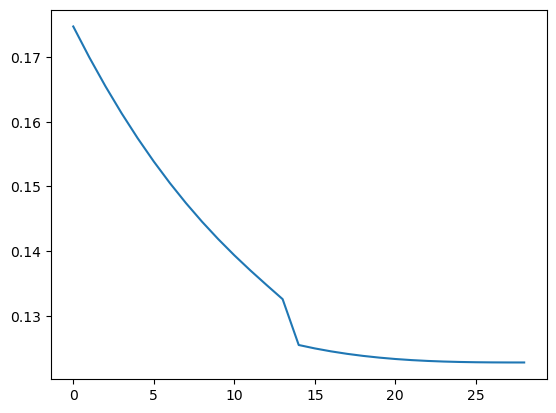

In [50]:
from scipy.stats import norm
put=[]
b1=[]
dd1=[]
d1=[]
K=bp
for k in range(1,l):
    b11,d11,cf11,d21=dollar_duration(b_mat,bp,bcr,li[k],cpy)
    if k < 15:
        sb=d21/100 ## using modified duration as bond price volatility
        T=15-k
        dp1=(np.log(b11/K)+(((sb**2)*T)/2))/(sb*np.sqrt(T))
        dp2=dp1-(sb*np.sqrt(T))
        p=(K*norm.cdf(-dp2)-b11*norm.cdf(-dp1))/(1+li[k])**k
        put.append(p)
        b1.append(b11+p)
        dd1.append(d11)
        d1.append(d21*0.0001*(b11+p))
    else:
        b1.append(b11)
        dd1.append(d11)
        d1.append(d21*0.0001*b11)
plt.plot(d1)

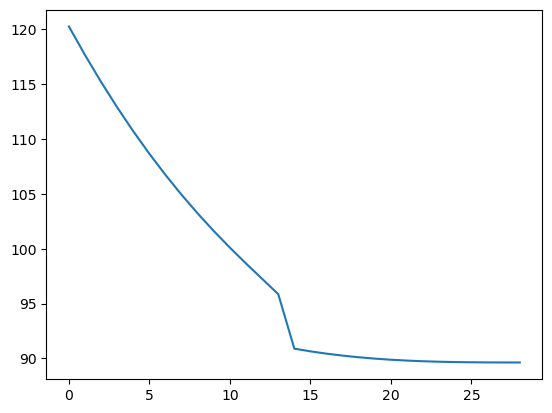

In [51]:
plt.plot(b1)

In [52]:
d1.index(max(d1))

0